In [1]:
%cd CPMP-ML

g:\My Drive\PUCV\CPMP_With_attetion\CPMP-ML


##Librerias Necesarias

In [29]:
import numpy as np
import pandas as pd
import keras
from keras.layers import Input, Add, Dense, MultiHeadAttention, LayerNormalization, Dropout, Flatten
from keras.models import Model, load_model
from keras.utils import to_categorical
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.metrics import accuracy_score
import cpmp_ml
import numpy as np
from cpmp_ml import generate_random_layout
import tensorflow as tf
from copy import deepcopy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
%cd ..

g:\My Drive\PUCV\CPMP_With_attetion


# Funciones necesarias

## Algoritmo Greedy y funciones para generación de datos

In [4]:
#************* | Función is_valid_BG_move() | ****************#
# El proposito de esta función es validar si el movimiento    #
# dentro del estado actual del problema actual al que se le   #
# desea realizar sirve para resolver el problema o no.        #  
#                                                             #
# Input:                                                      #
#     - layout: Variable que contiene el estado al que se     #
#               le desea realizar el movimiento.              #
#     - s_o: Stack de origen                                  #
#     - S_d: Stack de destino                                 #
#                                                             #
# Output:                                                     #
#     La función retorna True en caso de ser un movimiento    #
#     posible o False en caso contrario.                      #
def is_valid_BG_move(layout, s_o, s_d):
    if (s_o != s_d  and len(layout.stacks[s_o]) > 0
    and  len(layout.stacks[s_d]) < layout.H
    and layout.is_sorted_stack(s_o)==False
    and layout.is_sorted_stack(s_d)==True
    and layout.gvalue(s_o) <= layout.gvalue(s_d)):
      return True

    else: return False

In [5]:
#*********** | Función select_bg_move() | ************#
# El proposito de esta función es seleccionar un      #
# movimiento que optimice la diferencia entre las     #
# prioridades entre los contenedores del stack de     #
# destino y el stack de origen.                       #
#                                                     #
# Input:                                              #
#     - layout: Variable que contiene el estado       #
#               actual al que se le desea realizar    #
#               el movimiento.                        #
#                                                     #
# Output:                                             #
#   Retorna una tupla indicando el stack de origen    #
#   y el stack de destino que minimiza la             #
#   diferencia antes mencionada o en caso contrario   #
#   retorna None.                                     #
def select_bg_move(layout):
  bg_move = None # Tupla de movimiento optimo
  S=len(layout.stacks) # Cantidad de stacks
  min_diff = 100
  for s_o in range(S):
     for s_d in range(S):
       if is_valid_BG_move(layout, s_o, s_d):
          diff = layout.gvalue(s_d) - layout.gvalue(s_o)
          if min_diff > diff:
            min_diff = diff
            bg_move = (s_o,s_d)
  return bg_move

In [33]:
#************* | Función greedy | **************#
# El proposito de esta función es utilizar un   #
# algoritmo greedy para resolver el problema    #
# CPMP.                                         #
#                                               #
# Input:                                        #
#     - layout: El estado al cual se le desea   #
#               aplicar el algoritmo greedy     #
#               para resolverlo.                #
# Output:                                       #
#     La función retorna la cantidad de         #
#     movimientos que toma resolver el problema #
#     con el algoritmo y los movimientos que    #
#     debe llevar a cabo, en caso de no poder   #
#     ser resuelto retorna como cantidad de     #
#     pasos -1 y None en movimientos.           #
def greedy(layout):
    moves = []
    steps = 0
    while layout.unsorted_stacks>0:
        bg_move=select_bg_move(layout)
        if bg_move is not None:
            moves.append(bg_move)
            layout.move(bg_move)
        else:
            return -1, None # no lo resuelve
        steps +=1

    if layout.unsorted_stacks==0:
        return steps, moves
    return -1, None

In [27]:
#**************** | Función unlist() | ***************#
# El proposito de esta función es unificar las        #
# diversas listas de datos con los nuevos datos a     #
# ingresar.                                           #
#                                                     #
# Input:                                              #
#     - data: Lista de matrices principal.            #
#     - labels1: Lista de stacks de origen principal. #
#     - labels2: Lista de stacks de destino principal.#
#     - state: Lista de matrices con nuevos datos.    #
#     - source: Lista de stacks de origen con nuevos  #
#               datos.                                #
#     - destination: Lista de stacks de destino con   #
#                    nuevos datos.                    #
#                                                     #
# Output:                                             #
#     No retorna valores.                             #
def unlist(data,labels1, labels2, state, source, destination):
  n = len(source) # Cantidad de datos nuevos
  for i in range(n):
    data.append(state[i])
    labels1.append(source[i])
    labels2.append(destination[i])

In [28]:
#************* | get_ann_state() | **************#
# El proposito de esta función preparar los      #
# datos de un estado del problema CPMP para que  #
# pueda ser leído por una red neuronal.          #
#                                                #
# Input:                                         #
#     - layout: Estado actual del problema CPMP. #
#                                                #
# Output:                                        #
#     Retorna una matriz con los datos           #
#     normalizados.                              #
def get_ann_state(layout):
  S=len(layout.stacks) # Cantidad de stacks
  #matriz de stacks
  b = 2. * np.ones([S,layout.H + 1]) # Matriz normalizada
  for i,j in enumerate(layout.stacks):
     b[i][layout.H-len(j) + 1:] = [k/layout.total_elements for k in j]
     b[i][0] = layout.is_sorted_stack(i)
  b.shape=(S,(layout.H + 1))
  return b

#overriding the function in the module
cpmp_ml.get_ann_state = get_ann_state

In [9]:
#************ | convert_label() | ************#
# El proposito de esta función es convertir   #  
# una matriz en una lista con los datos       #
# apilados de forma que una red neuronal los  #
# use como etiquetas.                         #
#                                             #
# Input:                                      #
#     - score: Una matriz con datos binarios. #
#                                             #
# Output:                                     #
#      Retorna una lista con los datos de la  #
#      matriz apilados.                       #      
def convert_label(score):
    list_score = []

    for i in score:
        list_score.append(i)

    return np.array(list_score)

In [11]:
#************ | generate_steps_of_a_state() | *****************#
# El proposito de esta función es generar todos los            #
# movimientos que resuelven un estado a través de un algorimo  #
# greedy.                                                      #
#                                                              #
# Input:                                                       #
#     - layout: El estado actual que se desea resolver.        #
#                                                              #
# Output:                                                      #
#      - states: Lista de todos los estados de la solución.    #
#      - source_tags: Lista de todos los stacks de origen.     #
#      - destination_tags: Lista de todos los stacks de        #
#                          destino.                            #
#       En caso de no poder resolver el estado actual,         #
#       cada una de las variables antes mencionadas retorna    #
#       None.                                                  #
def generate_steps_of_a_state(layout):
    states = [] # estados antes de movimiento
    source_tags = [] # etiquetas origen
    destination_tags = []  # etiquetas destino

    aux = deepcopy(layout)  # creación de copia de objeto

    steps, moves = greedy(aux)
    if steps == -1:
      return None, None, None

    for i in range(steps):
        states.append(get_ann_state(layout)) # antes del movimiento
        source_tags.append(convert_label(to_categorical(moves[i][0],len(layout.stacks))))
        destination_tags.append(convert_label(to_categorical(moves[i][1],len(layout.stacks))))
        layout.move(moves[i])
        aux = deepcopy(layout)

    return states, source_tags, destination_tags

In [12]:
#*************** | create_different_states() | ***************#
# El proposito de esta función es crear diferentes            #
# estados para el problema CPMP con sus respectivas           #
# soluciones calculadas con un algoritmo greedy.              #
#                                                             #
# Input:                                                      #
#     - S: Cantidad de stacks.                                #
#     - H: Altura de los stacks                               #
#     - max_priority_container: la prioridad máxima de        #
#                               los contenedores y a la       #
#                               vez el total de contenedores. #
#     - n: cantidad de nuevos estados.                        #
# Output:                                                     #
#     Retorna arreglos que representan los distintos          #
#     estados con otros dos arreglos que contienen sus        #
#     posibles stacks de origen y de destino.                 #
def create_different_states(S, H, max_priority_container, n):
  data_state = []
  labels_source = []
  labels_destination = []
  iter = 0
  while iter < n:
    layout = generate_random_layout(S,H,max_priority_container)
    state, source, destination = generate_steps_of_a_state(layout)
    if state == None and source == None and destination == None: continue
    unlist(data_state,labels_source,labels_destination,state,source,destination)
    iter+=1

  return np.stack(data_state), np.stack(labels_source), np.stack(labels_destination)

## Funciones para entrenamiento y predicciones

In [13]:
#************ | expand_dims_cpmp() | **************#
# El proposito de esta función es expandir las     #
# dimensiones de un estado menor para que pueda    #
# ser predicho un por modelo para un estado mayor. #
#                                                  #
# Input:                                           #
#     - data: Lista de matrices con todos los      #
#             estados.                             #
#     - labels: lista de posibles stacks de origen #
#               o destino.                         #
#     - stacks: Cantidad de stacks permitidos por  #    
#               el modelo.                         #
#     - height: Altura máxima de los stacks        #
#               permitidos por el modelo.          #
#                                                  #
# Output:                                          #
#      Retona un arreglo de los datos              #
#      redimensionados con sus respectivos labels. #
def expand_dims_cpmp(data, labels, stacks, height):
    size = data.shape[1]
    tuple_data = zip(data, labels)
    data_2 = []
    labels_2 = []

    for matrix, label in tuple_data:
        matrix = matrix.tolist()
        label = label.tolist()
        for i in range(stacks - size):
            matrix.append([1] + [1 for n in range(height)])
            label.append(0)

        data_2.append(matrix)
        labels_2.append(label)

    return np.array(data_2), np.array(labels_2)

In [14]:
#*************** | concatenate_state_with_output() | ****************#
# El proposito de esta función es concatenar la data de las estados  #
# del problema con sus respectivos labels que indican el stack de    #
# origen.                                                            #
#                                                                    #
# Input:                                                             #
#     - states: Lista de matrices indicando los diversos estados.    #
#     - outputs: Lista de stacks de origen.                          #
#                                                                    #
# Output:                                                            # 
#      Retorna un arreglo con los datos concatenados.                #
def concatenate_state_with_output(states, outputs):
    size_stacks = len(states[0])
    size_height = len(states[0][0])
    tuple_data = zip(states, outputs)
    new_data = []

    for state, output in tuple_data:
        new_data.append([])

        for i in range(size_stacks):
            stack = state[i].tolist()
            stack.append(output[i])
            new_data[len(new_data) - 1].append(stack)

    return np.stack(new_data)

In [77]:
#************* | is_equal() | **************#
# El proposito de esta función es verificar #
# si los datos ingresados en dos arreglos   #
# son exactamente iguales independiente de  #
# su posición.                              #
#                                           #
# Input:                                    #
#     - array1: Primer arreglo que se       #
#               desea comparar.             #
#     - array2: Segundo arreglo que se      #
#               desea comparar.             #
# Output:                                   #
#     Retorna true en el caso de tener      #
#     cada dato exactamente igual o         #
#     False en caso contrario.              #
def is_equal(array1, array2):
    size = len(array1)
    cant = 0
    array1.sort()
    array2.sort()

    for i in range(size):
        if array1[i] == array2[i]:
            cant += 1

    if cant == size: return True

    return False

In [53]:
#***************** | precision() | ***************#
# El proposito de esta función es verificar si    #
# los valores predichos por una red neuronal son  #
# correctos o no.                                 #
#                                                 #
# Input:                                          #
#     - y_predict: Valores predichos por el       #
#                  mecanismo de machine learning. #
#     - y_test: Valores reales de los casos       #
#               predichos.                        #
# Output:                                         #
#     Retorna una proporción entre los valores    #
#     predichos correctamente sobre la cantidad   #
#     de datos.                                   #
def precision(y_predict, y_test):
    size = len(y_predict)
    predict = 0

    for i in range(size):
        if np.argmax(y_predict[i]) == np.argmax(y_test[i]):
            predict += 1
    
    return predict / size

In [80]:
#************** | precision_for_multiclass() | ***************#
# El proposito de esta función es verificar si los valores    #
# predichos por un mecanismo de machine learning para         #
# clasificación multiclase están correctos o no.              #
#                                                             # 
# Input:                                                      #
#     - y_predict: Valores predichos por el mecanismo de      #
#                  machine learning.                          #
#     - y_test: Valores reales de cada caso.                  #
# Output:                                                     #
#     Retorna una proporción entre los valores predichos      #
#     correctamente sobre la cantidad total de casos.         #
def precision_for_multiclass(y_predict, y_test):
    size = len(y_predict)
    predict = 0

    for i in range(size):
        cant_sol = np.count_nonzero(y_test[i] == 1.)
        
        indices_test = np.argsort(y_test[i])
        indices_test = indices_test[-cant_sol:]
        indices_predict = np.argsort(y_predict[i])
        indices_predict = indices_predict[-cant_sol:]

        if is_equal(indices_test, indices_predict):
            predict += 1
    
    return predict / size

## Funciones para cargar y guardar data

In [15]:
#***************** | save_data() | *****************#
# El proposito de esta función es almacenar datos   #
# de entrenamiento en un archivo csv.               #
#                                                   #
# Input:                                            #
#     - data: Lista de matrices con los estados     #
#             correspondientes.                     #
#     - labels_1: Lista con los posibles stacks de  #   
#                 origen.                           #
#     - labels_2: Lista con los posibles stacks de  #
#                 destino.                          #
#     - name: Dirección y/o nombre del archivo      #
#             sin el .csv.                          #
# Output:                                           #
#      No retorna valores.                          #
def save_data(data, labels_1, labels_2, name):
    size_stack = len(data[0])
    size_height = len(data[0][0])
    total_data = len(data)
    tuple_data = zip(data, labels_1, labels_2)

    with open(name + '.csv', 'w') as archivo:
        archivo.write('Total data: ' + str(total_data) + '\n')
        archivo.write('Stacks:' + str(size_stack) + ',Height:' + str(size_height) + '\n')
        archivo.write('\n')

        for matrix, label_1, label_2 in tuple_data:
            lista_stack = matrix.flatten()
            archivo.write('matrix:' + str(lista_stack.tolist())[1:-1] + '\n')
            archivo.write('label_1:' + str(label_1.tolist())[1:-1] + '\n')
            archivo.write('label_2:' + str(label_2.tolist())[1:-1] + '\n')
            archivo.write('\n')

        archivo.close()

In [16]:
#************** | load_data() | ************#
# El proposito de esta función es cargar    #
# los datos almacenados en un csv para el   #
# entrenamiento de la red neuronal.         #
#                                           #
# Input:                                    #
#     - name: Nombre del archivo con su     #
#             dirección correspondiente     #
#             sin el .csv.                  #
#                                           #
# Output:                                   #
#      Retorna 3 arreglos, el primero       #
#      corresponde a una lista de estados,  #
#      el segundo a una lista de labels     #
#      de stacks de origen y por último una #
#      lista de posibles stacks de destino. #
def load_data(name):
    data = []
    labels_1 = []
    labels_2 = []

    with open(name + '.csv', 'r') as archivo:
        total = int(archivo.readline().split(':')[1])
        line = archivo.readline().split(':')
        size_stacks = int(line[1].split(',')[0])
        size_height = int(line[2])
        archivo.readline()

        for i in range(total):
            matrix = archivo.readline().split(':')[1].split(',')
            matrix = np.array(matrix, dtype= float)
            matrix = np.reshape(matrix, (size_stacks, size_height))

            label_1 = archivo.readline().split(':')[1].split(',')
            label_1 = np.array(label_1, dtype= float)
            label_2 = archivo.readline().split(':')[1].split(',')
            label_2 = np.array(label_2, dtype= float)

            data.append(matrix)
            labels_1.append(label_1)
            labels_2.append(label_2)

            archivo.readline()

    return np.stack(data), np.stack(labels_1), np.stack(labels_2)

# Modelo de atención y clasificador de stacks

In [17]:
#********* | normalization_layer() | **********#
# El proposito de esta función es crear una    #
# capa que añada la salida de una capa de      #
# atención con el input realizado en el modelo #
# para disminuir la perdida de memoria y por   #
# último aplicar una capa de normalización.    #
#                                              #
# Input:                                       #
#     - input: Entrada que representa la       #
#              información a la cual se        #
#              le desea hacer incapie.         #
#     - attention: Output realizado por una    #
#                  capa de atención.           #
#                                              #
# Output:                                      #
#      Retorna la unión entre una capa de      #
#      normalización con la capa de unión.     # 
def normalization_layer(input, attention):
    layer = Add()([input,attention])
    layer = LayerNormalization(epsilon=1e-6)(layer)
    return layer

In [18]:
#************* | feed_forward_layer() | **************#
# El proposito de esta función es generar una capa de #
# feed para que el modelo pueda aprender de lo        #
# realizado en previamente a través de capas densas.  #
#                                                     #
# Input:                                              #
#     - input: Capa a la cual irá conectada.          #
#     - num_neuron: Número de neuronas.               #
# Output:                                             #
#     Retorna las conexiones de 2 capas densas con    #
#     el número de neuronas asignadas.                #
def feed_forward_layer(input, num_neuron):
    # capa de feed para que el modelo pueda aprender
    layer = Dense(num_neuron,activation='sigmoid')(input)
    layer = Dense(num_neuron)(layer)
    return layer

In [19]:
#****************** | attention_layer() | *******************#
# El proposito de esta funicón es generar una capa           #
# MultiHeadAttention con un cierto número de cabezales y     #
# con las conexiones entregadas.                             #
#                                                            #
# Input:                                                     #
#     - heads: Número de cabezales.                          #
#     - d_model: Dimensión de cada entrada dentro de la      #
#                capa.                                       #
#     - reshape: La conexión a una capa adyacente.           #
# Output:                                                    #
#     Retorna la conexión a una capa MultiHeadAttention.     #
def attention_layer(heads, d_model, reshape):
    attention = MultiHeadAttention(num_heads=heads, key_dim=d_model)(reshape,reshape)
    return attention

In [20]:
#*************** | stack_attention() | ***************#
# El proposito de esta función es generar un stack    #
# de capaz de atención.                               #
#                                                     #
# Input:                                              #
#     - heads: Número de cabezales dentro de la capa  #
#              de atención.                           #
#     - d_model: Dimensión de la entrada a la capa    #
#                de atención.                         #
#     - reshape: Capa de reshape realizado al input.  #
#     - input: Datos ingresados al modelo para        #
#              diminuir la perdida de memoria.        #
# Output:                                             #
#     Retorna todas las capas conectadas.             #
def stack_attention(heads, d_model, reshape, input):
    # por si se debe modificar la dimensión
    attention = attention_layer(heads,d_model,reshape)
    normalization = normalization_layer(input, attention)
    feed = feed_forward_layer(normalization, d_model)

    return feed

In [21]:
#*************** | create_model() | ****************#
# El proposito de esta función es generar el modelo #
# para resolver el problema CPMP con ayuda de capas #
# de atención, una capa Flatten, una Dropout y      #
# capaz Dense.                                      #
#                                                   #
# Input:                                            #
#     - heads: número de cabezales que se usarán    #
#              en la capa de atención.              #
#     - S: Cantidad máxima de stacks que aceptará   #
#          el modelo.                               #
#     - H: Altura máxima de los stacks que          #
#          aceptará el modelo.                      #
#     - optimizer: Optimizador que usará el         #
#                  modelo a la hora del             #
#                  entrenamiento.                   #   
# Output:                                           #
#     Retorna el modelo capaz de resolver el        #
#     problema CPMP.                                #
def create_model(heads, S, H , optimizer):
    input = Input(shape= (S, H+1))

    reshape = stack_attention(heads, H + 1, input, input)
    reshape = stack_attention(heads, H + 1, reshape, input)

    reshape = Flatten()(reshape)
    hidden1 = Dense(H * 6, activation='sigmoid')(reshape)
    dropout_1 = Dropout(0.5)(hidden1)
    hidden2 = Dense(H * 6, activation='sigmoid')(dropout_1)
    output = Dense(S,activation='softmax')(hidden2)

    model = Model(inputs=input,outputs=output)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['mae', 'mse', 'accuracy'])

    return model

In [56]:
#**#*********** | create_model_2() | ***************#
# El proposito de esta función es crear un modelo   #
# para resolver el problema CPMP con multiples      #
# stacks de origen o de destino.                    #
#                                                   #
# Input:                                            #
#     - heads: número de cabezales que se usarán    #
#              en la capa de atención.              #
#     - S: Cantidad máxima de stacks que aceptará   #
#          el modelo.                               #
#     - H: Altura máxima de los stacks que          #
#          aceptará el modelo.                      #
#     - optimizer: Optimizador que usará el         #
#                  modelo a la hora del             #
#                  entrenamiento.                   #   
# Output:                                           #
#     Retorna el modelo capaz de resolver el        #
#     problema CPMP.                                #
def create_model_2(heads, S, H , optimizer):
    input = Input(shape= (S, H+1))

    reshape = stack_attention(heads, H + 1, input, input)
    reshape = stack_attention(heads, H + 1, reshape, input)

    reshape = Flatten()(reshape)
    hidden1 = Dense(H * 6, activation='sigmoid')(reshape)
    dropout_1 = Dropout(0.5)(hidden1)
    hidden2 = Dense(H * 6, activation='sigmoid')(dropout_1)
    output = Dense(S,activation='sigmoid')(hidden2)

    model = Model(inputs= input,outputs= output)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics= ['mae', 'mse', 'accuracy'])

    return model

# Modelo Output (Con una sola salida)

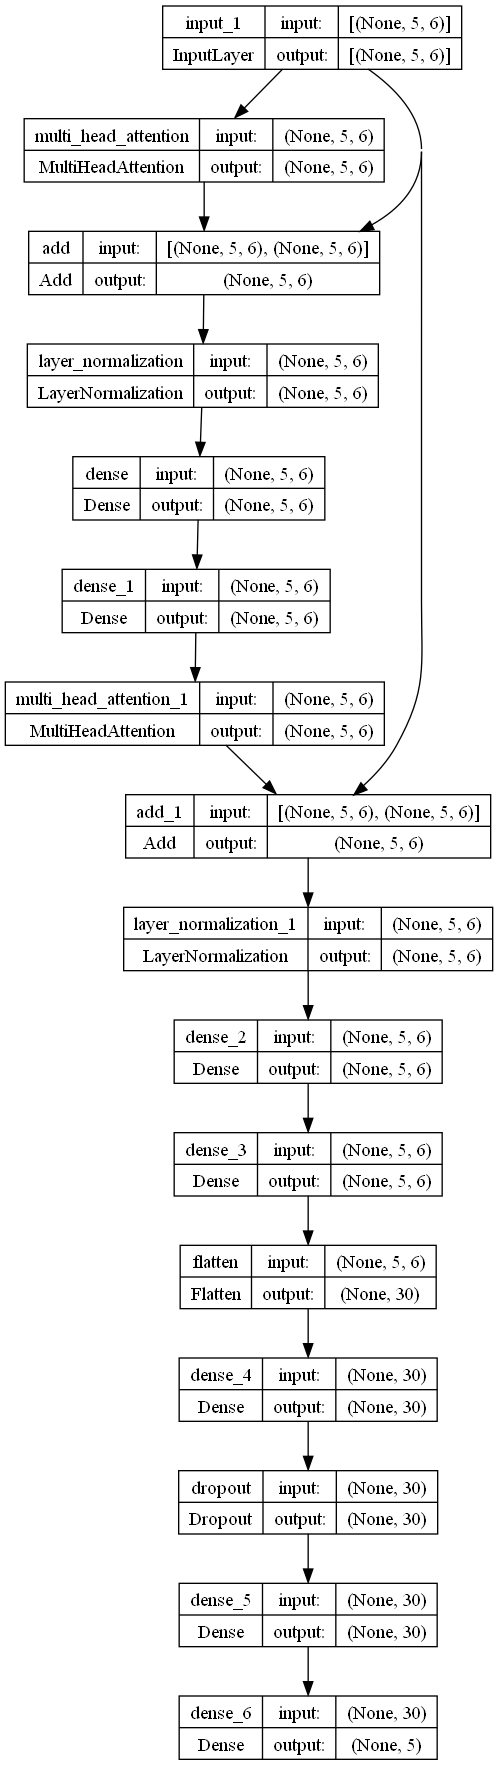

In [22]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')
model_cpmp_origin_5x5 = create_model(heads= 5, S= 5, H= 5, optimizer= optimizer)
keras.utils.plot_model(model_cpmp_origin_5x5, show_shapes=True, to_file= 'images_models/model_cpmp_origin_5x5.png')

# Generador de data

In [ ]:
# Cantidad de stacks
S = 5#@param {type:'slider',min:1,max:1000,steps:1}

# Altura de la bahía
H = 7#@param {type:'slider',min:1,max:1000,steps:1}

# Número máximo de prioridad
MPC = 32 #@param {type:'slider',min:1,max:1000,steps:1}

# Cantida casos de entrenamiento
N = 10000 #@param {type:'slider',min:1,max:100000,steps:1}

X_train, y_train_1, y_train_2 = create_different_states(S, H, MPC, N)

In [46]:
# Cantidad de stacks
S2 = 3 #@param {type:'slider',min:1,max:100,steps:1}

# Altura de la bahía
H2 = 7 #@param {type:'slider',min:1,max:100,steps:1}

# Número máximo de prioridad
MPC2 = 12 #@param {type:'slider',min:1,max:100,steps:1}

# Cantida casos de prueba
N2 = 500 #@param {type:'slider',min:1,max:10000,steps:1}

X_test, y_test_1, y_test_2 = create_different_states(S2, H2, MPC2, N2)

# Cargar Data

In [61]:
data_7x7, labels_1_7x7, labels_2_7x7 = load_data('data/data_7x7')

In [30]:
data_5x5, labels_1_5x5, labels_2_5x5 = load_data('data/data_5x5')

In [57]:
data_5x5_multi, labels_1_5x5_multi, labels_2_5x5_multi = load_data('data/data_5x5_SO_Multiple_alpha')

# Entrenamiento y pruebas

## Modelo 5x5

In [32]:
model_cpmp_origin_5x5 = load_model('models/model_cpmp_origin_5x5.h5')

In [31]:
X_train_5x5, X_test_5x5, y_train_1_5x5, y_test_1_5x5 = train_test_split(data_5x5, labels_1_5x5, test_size= 0.2, random_state= 42)

Text(0.5, 0.98, 'Modelo CPMP origen 5x5')

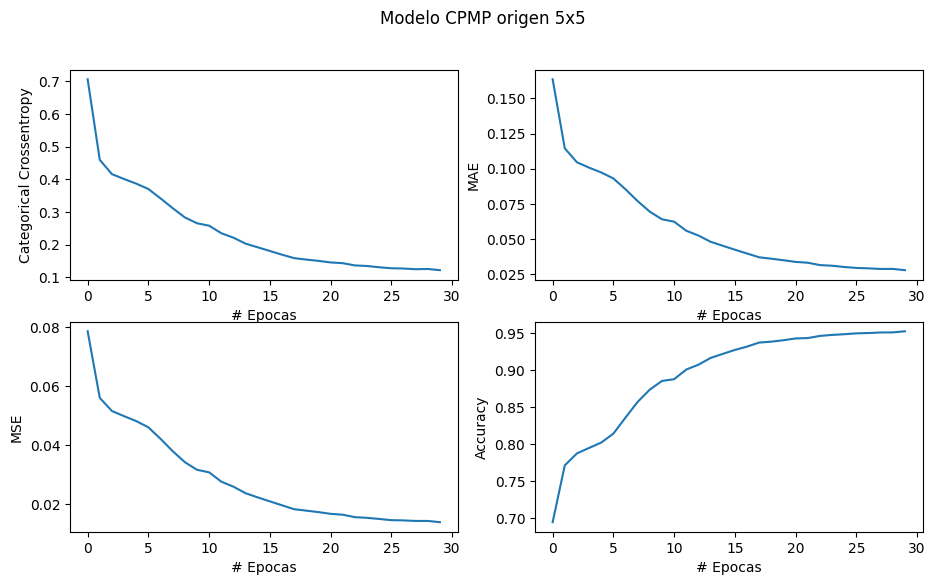

In [49]:
plt.figure(figsize=(11, 6)) 

plt.subplot(2,2,1)
plt.xlabel("# Epocas")
plt.ylabel("Categorical Crossentropy")
plt.plot(history.history["loss"])

plt.subplot(2,2,2)
plt.xlabel("# Epocas")
plt.ylabel("MAE")
plt.plot(history.history["mae"])

plt.subplot(2,2,3)
plt.xlabel("# Epocas")
plt.ylabel("MSE")
plt.plot(history.history["mse"])

plt.subplot(2,2,4)
plt.xlabel("# Epocas")
plt.ylabel("Accuracy")
plt.plot(history.history["accuracy"])

plt.suptitle("Modelo CPMP origen 5x5")


In [35]:
predict_5x5 = model_cpmp_origin_5x5.predict(X_test_5x5)

1556/1556 [==============================] - 5s 3ms/step


In [43]:
y_test_1_5x5

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [44]:
predict_5x5

array([[9.9955767e-01, 6.2567422e-05, 2.2499743e-04, 5.6765348e-05,
        9.8047400e-05],
       [9.9930620e-01, 6.0971699e-05, 2.6436095e-04, 1.1598291e-04,
        2.5251010e-04],
       [5.1297789e-05, 2.7377193e-05, 3.3575081e-04, 9.9954993e-01,
        3.5594734e-05],
       ...,
       [2.5221028e-03, 1.8499292e-03, 1.6516261e-03, 8.8336150e-04,
        9.9309301e-01],
       [4.6339992e-04, 9.2113227e-01, 2.1249526e-04, 7.7910624e-02,
        2.8123488e-04],
       [1.3810356e-01, 2.1507223e-04, 4.8510928e-04, 8.6075222e-01,
        4.4397713e-04]], dtype=float32)

In [54]:
y_test_1_5x5 = np.array(y_test_1_5x5) 
predict_5x5 = np.array(predict_5x5)
result = precision(y_test_1_5x5, predict_5x5)
print(f"Porcentaje de acierto: {round(result * 100, 2)}%")

Porcentaje de acierto: 94.81%


## Modelo 7x7

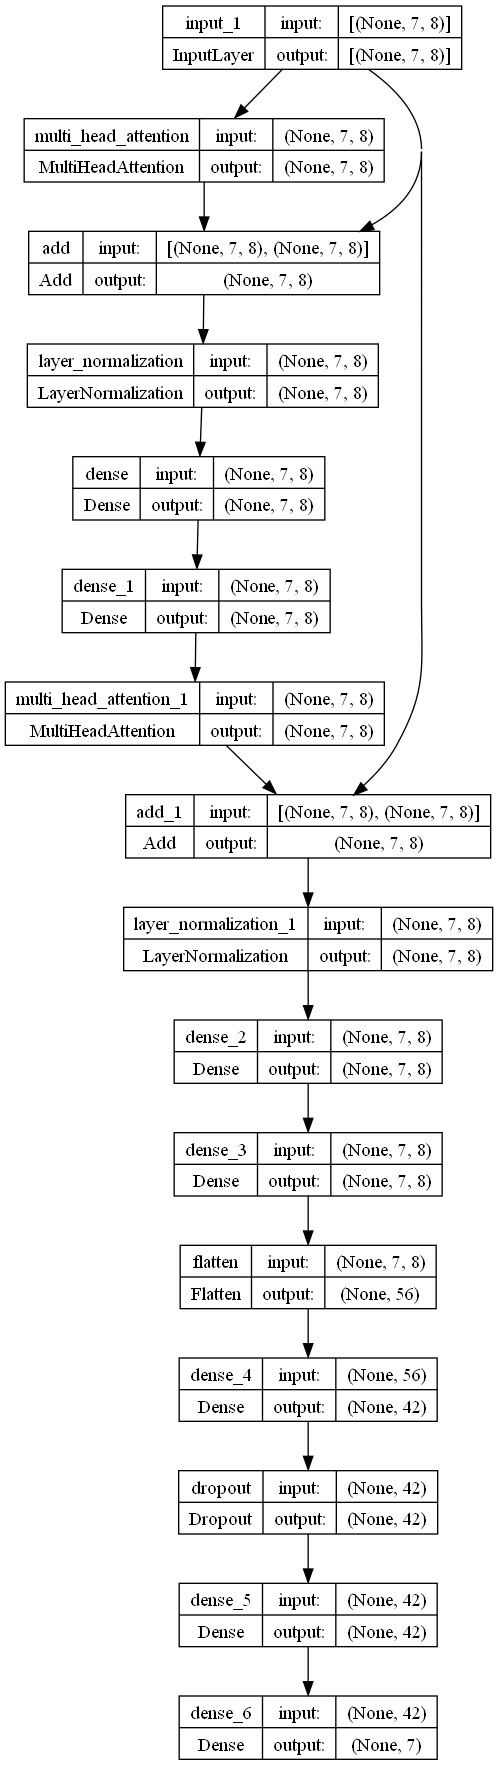

In [68]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')
model_cpmp_origin_7x7 = create_model(heads= 5, S= 7, H= 7, optimizer= optimizer)
keras.utils.plot_model(model_cpmp_origin, show_shapes=True, to_file= 'images_models/model_cpmp_origin_5x5.png')

In [64]:
X_train_7x7, X_test_7x7, y_train_1_7x7, y_test_1_7x7 = train_test_split(data_7x7, labels_1_7x7, test_size= 0.2, random_state= 42)

In [69]:
historial_7x7 = model_cpmp_origin_7x7.fit(X_train_7x7, y_train_1_7x7, batch_size= 32, epochs= 60)

Epoch 1/60
4244/4244 [==============================] - 17s 3ms/step - loss: 1.2244 - mae: 0.1790 - mse: 0.0879 - accuracy: 0.4915
Epoch 2/60
4244/4244 [==============================] - 14s 3ms/step - loss: 0.9562 - mae: 0.1524 - mse: 0.0752 - accuracy: 0.5457
Epoch 3/60
4244/4244 [==============================] - 14s 3ms/step - loss: 0.8484 - mae: 0.1391 - mse: 0.0688 - accuracy: 0.5906
Epoch 4/60
4244/4244 [==============================] - 14s 3ms/step - loss: 0.7822 - mae: 0.1293 - mse: 0.0641 - accuracy: 0.6301
Epoch 5/60
4244/4244 [==============================] - 14s 3ms/step - loss: 0.7363 - mae: 0.1217 - mse: 0.0603 - accuracy: 0.6603
Epoch 6/60
4244/4244 [==============================] - 14s 3ms/step - loss: 0.7057 - mae: 0.1167 - mse: 0.0579 - accuracy: 0.6778
Epoch 7/60
4244/4244 [==============================] - 14s 3ms/step - loss: 0.6787 - mae: 0.1123 - mse: 0.0558 - accuracy: 0.6906
Epoch 8/60
4244/4244 [==============================] - 15s 3ms/step - loss: 0.6491

Text(0.5, 0.98, 'Modelo CPMP origen 7x7')

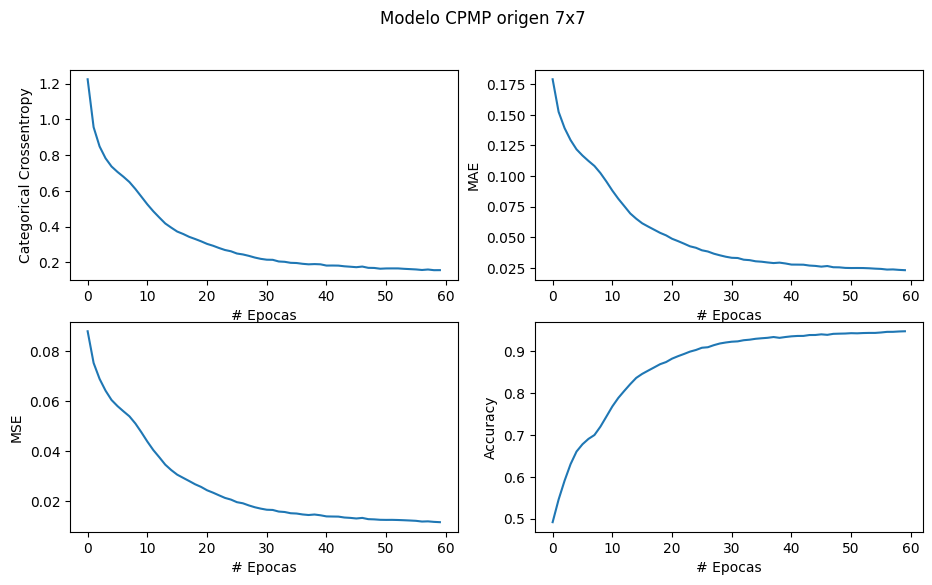

In [71]:
plt.figure(figsize=(11, 6)) 

plt.subplot(2,2,1)
plt.xlabel("# Epocas")
plt.ylabel("Categorical Crossentropy")
plt.plot(historial_7x7.history["loss"])

plt.subplot(2,2,2)
plt.xlabel("# Epocas")
plt.ylabel("MAE")
plt.plot(historial_7x7.history["mae"])

plt.subplot(2,2,3)
plt.xlabel("# Epocas")
plt.ylabel("MSE")
plt.plot(historial_7x7.history["mse"])

plt.subplot(2,2,4)
plt.xlabel("# Epocas")
plt.ylabel("Accuracy")
plt.plot(historial_7x7.history["accuracy"])

plt.suptitle("Modelo CPMP origen 7x7")

In [72]:
predict_7x7 = model_cpmp_origin_7x7.predict(X_test_7x7)

1061/1061 [==============================] - 2s 2ms/step


In [73]:
result = compare(predict_7x7, y_test_1_7x7)
print(f"Porcentaje de acierto: {round(result * 100, 2)}%")

Porcentaje de acierto: 95.66%


# Modelo Input (Con una sola salida)

In [75]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')
model_cpmp_dest = create_model(heads= 5, S= 7, H= 7 + 1, optimizer= optimizer)

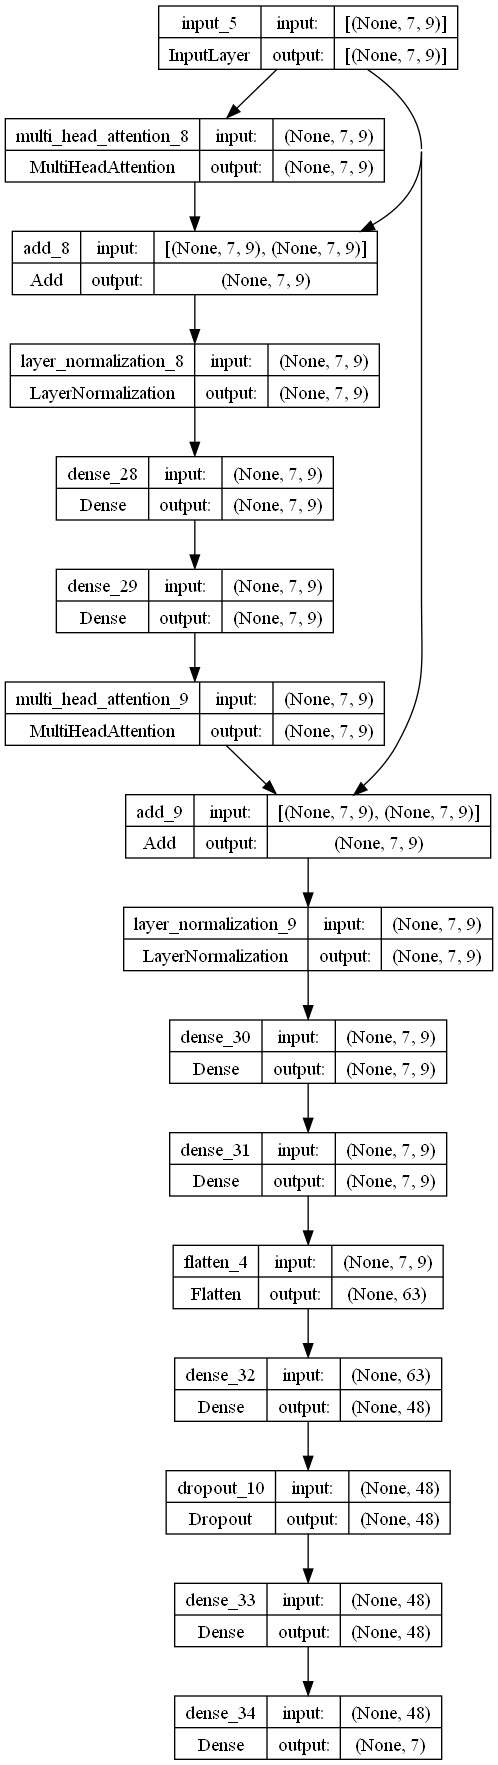

In [76]:
keras.utils.plot_model(model_cpmp_dest,show_shapes=True, to_file= 'images_models/model_cpmp_dest_7x7.png')

In [79]:
X_train, y_train_1, y_train_2 = load_data('data/data_7x7')

In [80]:
X_train_2 = concatenate_state_with_output(X_train, y_train_1)

In [82]:
model_cpmp_dest.fit(X_train_2, y_train_2, batch_size= 32, epochs= 1)

5304/5304 [==============================] - 16s 3ms/step - loss: 0.1469 - mae: 0.0220 - mse: 0.0106 - accuracy: 0.9498


In [83]:
model_cpmp_dest.save('models/model_cpmp_dest_7x7.h5')

c:\Users\matia\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Modelo con Varias Salidas

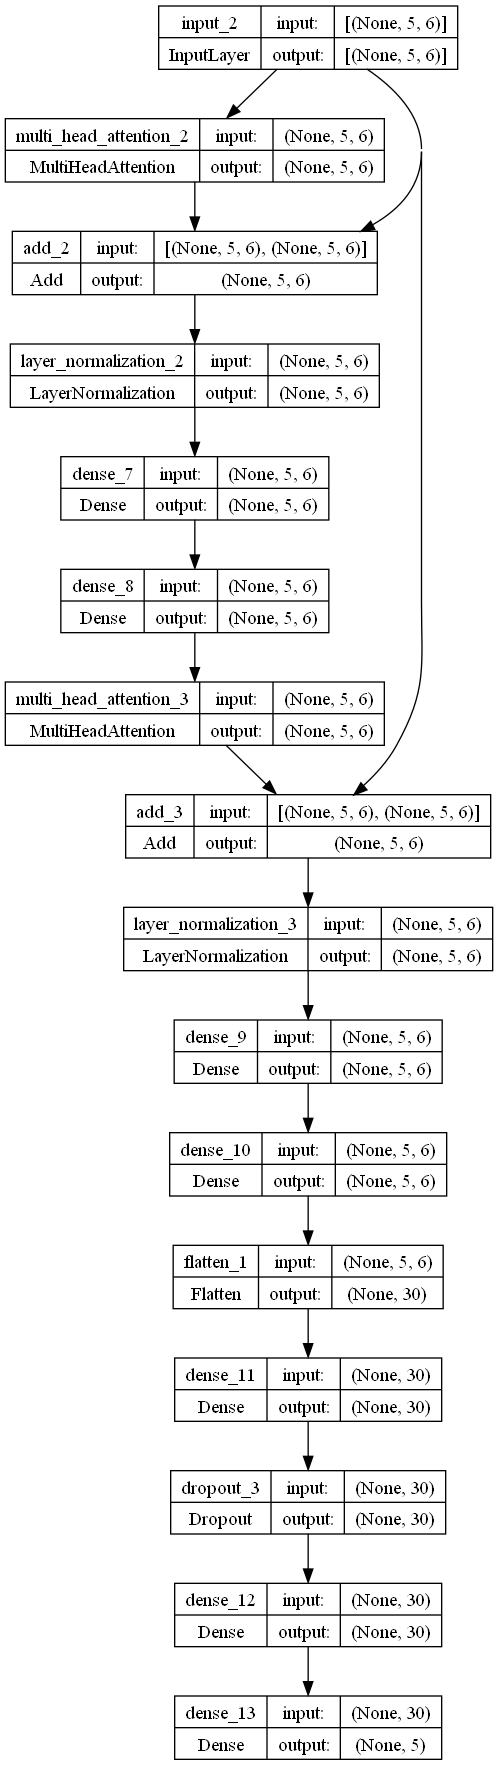

In [55]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')
model_cpmp_origin_5x5_multi = create_model(heads= 5, S= 5, H= 5, optimizer= optimizer)
keras.utils.plot_model(model_cpmp_origin_5x5, show_shapes=True, to_file= 'images_models/model_cpmp_origin_5x5.png')

In [58]:
X_train_5x5_multi, X_test_5x5_multi, y_train_1_5x5_multi, y_test_1_5x5_multi = train_test_split(data_5x5_multi, labels_1_5x5_multi, test_size= 0.2, random_state= 42)

In [60]:
hitorial_5x5_multi = model_cpmp_origin_5x5_multi.fit(X_train_5x5_multi, y_train_1_5x5_multi, batch_size= 32, epochs= 40)

Epoch 1/40
5000/5000 [==============================] - 23s 5ms/step - loss: 0.3215 - mae: 0.2177 - mse: 0.1056 - accuracy: 0.5354
Epoch 2/40
5000/5000 [==============================] - 23s 5ms/step - loss: 0.2782 - mae: 0.1831 - mse: 0.0900 - accuracy: 0.5901
Epoch 3/40
5000/5000 [==============================] - 22s 4ms/step - loss: 0.2582 - mae: 0.1682 - mse: 0.0830 - accuracy: 0.6079
Epoch 4/40
5000/5000 [==============================] - 23s 5ms/step - loss: 0.2351 - mae: 0.1507 - mse: 0.0746 - accuracy: 0.6291
Epoch 5/40
5000/5000 [==============================] - 23s 5ms/step - loss: 0.2162 - mae: 0.1374 - mse: 0.0680 - accuracy: 0.6435
Epoch 6/40
5000/5000 [==============================] - 23s 5ms/step - loss: 0.1999 - mae: 0.1261 - mse: 0.0625 - accuracy: 0.6509
Epoch 7/40
5000/5000 [==============================] - 23s 5ms/step - loss: 0.1897 - mae: 0.1188 - mse: 0.0589 - accuracy: 0.6552
Epoch 8/40
5000/5000 [==============================] - 23s 5ms/step - loss: 0.1829

In [62]:
predict_5x5_multi = model_cpmp_origin_5x5_multi.predict(X_test_5x5_multi)

1250/1250 [==============================] - 2s 2ms/step


In [81]:
result = precision_for_multiclass(predict_5x5_multi, y_test_1_5x5_multi)
print(f"Porcentaje de acierto: {round(result * 100, 2)}%")

Porcentaje de acierto: 96.16%
